**Import**

In [ ]:
import os
import argparse, random, copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from matplotlib import pyplot as plt
from torchvision.models import ResNet50_Weights, ResNet18_Weights

import torchvision.utils as vutils

import time
import torch.nn.init as init

from collections import defaultdict
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Subset, random_split
from random import randrange

from tqdm.autonotebook import tqdm

**Path where to save and reload the model**

In [ ]:
PATH = './'

**Meta-Learning**

In [ ]:
#metalearning
from copy import deepcopy
INNEREPOCHS = 30 # number of epochs for each inner ADAM; 80 is better
outerstepsize0 = 0.01 # stepsize of outer optimization, i.e., meta-optimization
NITERATION = 40000 # number of outer updates; each iteration, we sample one task and update on it

def create_single_class_loader(dataset, batch_size):
    # This train loader with batch size 1 is only used at the beginning,
    # then it gets overwritten *
    temp_loader = DataLoader(
        dataset,
        shuffle=True,
        batch_size=1
    )

    # Create N_CLASS different loaders (one for each number)
    loaders_list = [[] for _ in range(N_CLASS)]

    for img, label in temp_loader:
        loaders_list[label.item()].append((img[0], label))

    loader_single_class = []
    for data_list in loaders_list:
        x = torch.stack(list(zip(*data_list))[0])
        y = torch.stack(list(zip(*data_list))[1])

        dataset = TensorDataset(x, y)
        # Every time the dataset is iterated, it is shuffled randomly
        loader_single_class.append(DataLoader(
                dataset,
                sampler=RandomSampler(dataset),
                batch_size=batch_size
            )
        )

    return loader_single_class

# antidomain in this context = negative
class create_antidomain(Dataset):
    def __init__(self, root, train, download=False):
        super(create_antidomain, self).__init__()

        # Get CIFAR dataset
        if CIFAR:
            self.dataset = datasets.CIFAR100(root, train=train, download=download, transform = transform)
        else:
            self.dataset = datasets.MNIST(root, train=train, download=download, transform = transform)

        self.data = torch.stack([img for img, _ in self.dataset], dim=0)
        self.group_examples()

    def group_examples(self):
        np_arr = np.array(self.dataset.targets)

        # Group examples based on class
        self.grouped_examples = {}
        for i in range(0, N_CLASS-K_WAY):
            self.grouped_examples[i] = np.where((np_arr==i))[0]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        ###FULL DOMAIN
        selected_class = random.randint(0, N_CLASS-K_WAY-1)
        random_index_1 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        index_1 = self.grouped_examples[selected_class][random_index_1]
        img = self.data[index_1].clone()

        return img, selected_class

**MNIST or CIFAR**

In [ ]:
CIFAR = True #True: CIFAR100; False: MNIST

K_WAY = 10 # 10 classes excluded during training

if CIFAR:
    N_CLASS = 100 #for cifar100 = 100, cifar10 = 10 etc... if K_WAY == 0 the model learns every class
else:
    N_CLASS = 10

if CIFAR:
    MEAN = (0.4914, 0.4822, 0.4465)
    STD = (0.2023, 0.1994, 0.2010)
    transform = T.Compose([
        #T.RandomRotation(degrees=15),  # Modifica l'angolo a tuo piacimento
        #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #T.ElasticTransform(alpha=50.0, sigma=5.0),

        #T.RandomCrop(32, padding=4),
        #T.RandomResizedCrop(size=32, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=2),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(MEAN, STD)
    ])
else:

    transform = T.Compose([
        T.ToTensor()
    ])

**Net**

In [ ]:
class Arguments:
    def __init__(self, batch_size=64, test_batch_size=1000, epochs=14, lr=0.001,
                 no_cuda=False, no_mps=False, dry_run=False, seed=1,
                 log_interval=10, save_model=True):
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.epochs = epochs
        self.lr = lr
        self.no_cuda = no_cuda
        self.no_mps = no_mps
        self.dry_run = dry_run
        self.seed = seed
        self.log_interval = log_interval
        self.save_model = save_model

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SiameseNetwork(nn.Module): #ResNet from https://github.com/akamaster/pytorch_resnet_cifar10
    def __init__(self, block = BasicBlock, num_blocks = [5, 5, 5]):
        super(SiameseNetwork, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        #self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        output = out.view(out.size()[0], -1)

        return output


class TripletLoss_Cosine(nn.Module):
    def __init__(self, margin=0.3):
        super(TripletLoss_Cosine, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        cos_sim_pos = F.cosine_similarity(anchor, positive)
        cos_sim_neg = F.cosine_similarity(anchor, negative)
        loss = torch.relu(cos_sim_neg - cos_sim_pos + self.margin)
        return loss.mean()

**Train and Test Functions**

In [ ]:
def train_on_task(args, model, device, single_loader, train_loader, optimizer, random, innerepochs):
    for i in range(innerepochs):
        # clear out the gradients of Variables
        model.zero_grad()

        current_domain = random

        anchor = next(iter(single_loader[current_domain]))
        positive = next(iter(single_loader[current_domain]))
        negative = next(iter(train_loader))
        negative[1] = negative[1].view(positive[1].size(0), 1)

        #I make the images of the current domain invisible through "censorship"
        ######################################################################################
        for j in range(len(negative[1])):
            if negative[1][j].item() == current_domain:
                # censored with a redundancy of images
                while negative[1][j].item() == current_domain:
                    rnd = randrange(len(negative[1]))
                    negative[0][j] = negative[0][rnd]
                    negative[1][j] = negative[1][rnd]

        criterion = TripletLoss_Cosine()

        #No label
        anchor, positive, negative = anchor[0], positive[0], negative[0]
        #To Cuda
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        if not CIFAR:
            anchor = anchor.repeat(1,3,1,1)
            positive = positive.repeat(1,3,1,1)
            negative = negative.repeat(1,3,1,1)

        optimizer.zero_grad()

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        loss = criterion(anchor_output, positive_output, negative_output)

        #loss.backward(retain_graph=True)
        loss.backward()

        optimizer.step()

    return loss

def test(args, model, device, single_loader, test_loader, optimizer, task):
    current_domain = task
    correct = 0
    total = 0

    with torch.no_grad():
        test_anchor_data = next(iter(single_loader[current_domain]))
        test_positive_data = next(iter(single_loader[current_domain]))
        test_negative_data = next(iter(test_loader))
        test_negative_data[1] = test_negative_data[1].view(test_positive_data[1].size(0), 1)


        #CREATE IMGS2, RANDOM BATCH WITH 50% TASK
        #I make the images of the current domain invisible through "censorship"
        ######################################################################################
        for j in range(len(test_negative_data[1])):
            if test_negative_data[1][j].item() == current_domain:
                #censored with a redundancy of images
                while test_negative_data[1][j].item() == current_domain:
                    rnd = randrange(len(test_negative_data[1]))
                    test_negative_data[0][j] = test_negative_data[0][rnd]
                    test_negative_data[1][j] = test_negative_data[1][rnd]

        test_anchor = test_anchor_data[0]
        test_positive = test_positive_data[0]
        test_negative = test_negative_data[0]

        # Extract random 500 index from each dataset
        indices_negative = random.sample(range(test_negative_data[1].size(0)), test_negative_data[1].size(0)//2)
        indices_positive = random.sample(range(test_positive_data[1].size(0)), test_positive_data[1].size(0)//2)

        # Select sample from extracted index
        selected_negative_0 = test_negative_data[0][indices_negative]
        selected_positive_0 = test_positive_data[0][indices_positive]
        selected_negative_1 = test_negative_data[1][indices_negative]
        selected_positive_1 = test_positive_data[1][indices_positive]

        # Create tensor concatenating selected samples
        test_concat = torch.cat([selected_negative_0, selected_positive_0], dim=0)
        labs2 = torch.cat([selected_negative_1, selected_positive_1], dim=0)

        # Generate random permutation of index along dim 0
        random_indices = torch.randperm(test_positive_data[1].size(0))

        # Sort imgs2 and labs2 using random index
        test_concat = test_concat[random_indices]
        labs2 = labs2[random_indices]

        test_anchor, test_positive, test_negative, test_concat = test_anchor.to(device), test_positive.to(device), test_negative.to(device), test_concat.to(device)

        if not CIFAR:
            test_anchor = test_anchor.repeat(1,3,1,1)
            test_positive = test_positive.repeat(1,3,1,1)
            test_negative = test_negative.repeat(1,3,1,1)

            test_concat = test_concat.repeat(1,3,1,1)

        test_anchor_output = model(test_anchor)
        test_positive_output = model(test_positive)
        test_negative_output = model(test_negative)
        test_concat_output = model(test_concat)

        #Cosine distance
        dist_pos = F.cosine_similarity(test_anchor_output, test_positive_output, dim=1)
        dist_neg = F.cosine_similarity(test_anchor_output, test_negative_output, dim=1)
        dist_concat = F.cosine_similarity(test_anchor_output, test_concat_output, dim=1)
        correct += torch.sum(dist_pos > dist_neg).item()
        total += len(test_anchor)

    # Correct triplete
    accuracy = 100.0 * correct / total
    print('Test Accuracy [TASK: {:d}]:{:.2f}%'.format(current_domain, accuracy))
    return accuracy

def binary_test_meta(model, device, single_loader_test, full_loader_test, task):
    #ANCHOR IS CURRENT TASK
    correct = 0
    total = 0
    current_domain = task

    with torch.no_grad():
        anchor = next(iter(single_loader_test[current_domain]))
        positive = next(iter(single_loader_test[current_domain]))
        negative = next(iter(full_loader_test))
        negative[1] = negative[1].view(positive[1].size(0), 1)

        #CREATE IMGS1, A BATCH OF TASK
        imgs1 = anchor[0]
        labs1 = anchor[1]

        #CREATE IMGS2, RANDOM BATCH WITH 50% TASK
        # Make images from the current domain invisible through "censorship"
        ######################################################################################
        for j in range(len(negative[1])):
            if negative[1][j].item() == current_domain:
                # Censor with redundancy of images
                while negative[1][j].item() == current_domain:
                    rnd = randrange(len(negative[1]))
                    negative[0][j] = negative[0][rnd]
                    negative[1][j] = negative[1][rnd]

        # Extract random index from each dataset
        indices_negative = random.sample(range(positive[1].size(0)), positive[1].size(0)//2)
        indices_positive = random.sample(range(positive[1].size(0)), positive[1].size(0)//2)

        # Select sample from extracted index
        selected_negative_0 = negative[0][indices_negative]
        selected_positive_0 = positive[0][indices_positive]
        selected_negative_1 = negative[1][indices_negative]
        selected_positive_1 = positive[1][indices_positive]

        # Create tensor concatenating selected samples
        imgs2 = torch.cat([selected_negative_0, selected_positive_0], dim=0)
        labs2 = torch.cat([selected_negative_1, selected_positive_1], dim=0)

        # Generate random permutation along dim 0
        random_indices = torch.randperm(positive[1].size(0))

        # Sort imgs2 and labs2 using random index
        imgs2 = imgs2[random_indices]
        labs2 = labs2[random_indices]

        targets = (labs1 == labs2).float()
        targets = targets.squeeze()

        imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)

        if not CIFAR:
            imgs1 = imgs1.repeat(1,3,1,1)
            imgs2 = imgs2.repeat(1,3,1,1)

        output1 = model(imgs1)
        output2 = model(imgs2)

        # Predict whether images belong to the same class
        distance = F.cosine_similarity(output1, output2, dim=1)
        pred = (distance > 0.7).to(torch.float32) #forse la distance è 0.4
        correct += torch.sum(pred == targets).item()
        total += len(imgs1)

    accuracy = 100.0 * correct / total
    print('Binary Test Accuracy META [TASK: {:d}]: {:.2f}%'.format(current_domain, accuracy))

    return accuracy

**Prepare dataset**

In [ ]:
# Training settings
batch_size = 128 #input batch size for training (default: 128)]
if CIFAR: #input batch size for testing (max: 50 on cifar and 256 on mnist)
    test_batch_size = 50
else:
    test_batch_size = 256

test_batch_size_binary = 1000 #input batch size for testing (default: 1000)
epochs = 500 #number of epochs to train (default: 14)
lr = 0.001 #learning rate (default: 0.001)
no_cuda = False #disables CUDA training
no_mps = False #disables macOS GPU training
dry_run = False #quickly check a single pass
seed = 1 #random seed (default: 1)
log_interval = 10 #how many batches to wait before logging training status
save_model = True #For Saving the current Model

#It's inconvenient to switch to the command line for colab, so I created my own args class
args = Arguments(batch_size=batch_size, test_batch_size=test_batch_size, epochs=epochs, lr=lr,
                  no_cuda=no_cuda, no_mps=no_mps, dry_run=dry_run, seed=seed,
                  log_interval=log_interval, save_model=save_model)
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
torch.manual_seed(args.seed)
if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#TRAIN dataset
if CIFAR:
    train_dataset = datasets.CIFAR100('../data', train=True, download=True, transform = transform)
else:
    train_dataset = datasets.MNIST('../data', train=True, download=True, transform = transform)

single_loader_train = create_single_class_loader(train_dataset, args.batch_size)
full_dataset_train = create_antidomain('../data', train=True, download=True)
full_loader_train = torch.utils.data.DataLoader(full_dataset_train, args.batch_size)

#TEST dataset
if CIFAR:
    test_dataset = datasets.CIFAR100('../data', train=False, download=True, transform = transform)
else:
    test_dataset = datasets.MNIST('../data', train=False, download=True, transform = transform)

single_loader_test = create_single_class_loader(test_dataset, args.test_batch_size)
full_dataset_test = create_antidomain('../data', train=False, download=True)
full_loader_test = torch.utils.data.DataLoader(full_dataset_test, args.test_batch_size)

if CIFAR:
    model = SiameseNetwork(num_blocks = [9, 9, 9]).to(device) #ResNet56
else:
    model = SiameseNetwork(num_blocks = [3, 3, 3]).to(device) #ResNet20

optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer2 = optim.Adam(model.parameters(), lr=0.001) #fast move for meta-gradient

#Resume Training
path = PATH+"siamese_network_META_CIFAR100_.pth"
if os.path.exists(path):
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    n_iteration = checkpoint['iteration']

    print("- Checkpoint found, I resume training")
else:
    n_iteration = 1
    print("- A pre-trained model was not found, I proceed with new training.")

100%|██████████| 169001437/169001437 [00:13<00:00, 12285694.50it/s]


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
- Checkpoint found, I resume training


**Show anchor (task 0):**

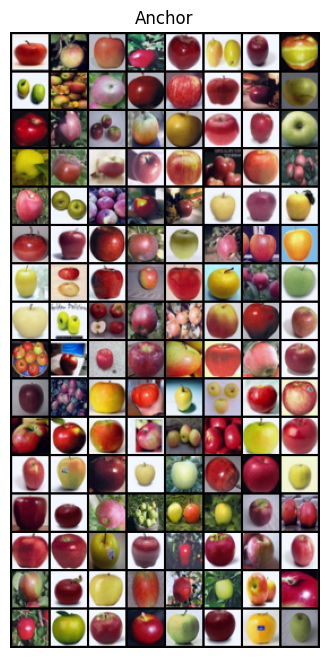

In [ ]:
T = 0 #Select task
anc = next(iter(single_loader_train[T]))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Anchor")
plt.imshow(np.transpose(vutils.make_grid(anc[0].to(device)[:], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

**Show positive for task 0**

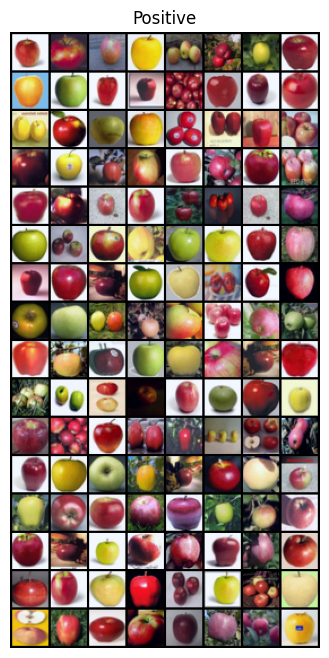

In [ ]:
pos = next(iter(single_loader_train[T]))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Positive")
plt.imshow(np.transpose(vutils.make_grid(pos[0].to(device)[:], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

**Show negative for task 0 (antidomain + censor)**

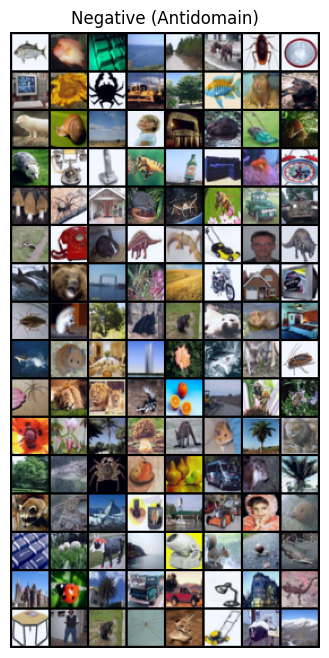

In [ ]:
neg = next(iter(full_loader_train))

# Make images from the current domain invisible through "censorship"
######################################################################################
for j in range(len(neg[1])):
    if neg[1][j].item() == T:
        # Censor with redundancy of images
        while neg[1][j].item() == T:
            rnd = randrange(len(neg[1]))
            neg[0][j] = neg[0][rnd]
            neg[1][j] = neg[1][rnd]

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Negative (Antidomain)")
plt.imshow(np.transpose(vutils.make_grid(neg[0].to(device)[:], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

**Reptile training loop**

In [ ]:
# Reptile training loop
for iteration in tqdm(range(n_iteration, NITERATION+1)):

    ### TRAIN ###
    model.train()
    dado = randrange(N_CLASS-K_WAY) #generate task
    #Clone Model
    weights_before_model = deepcopy(model.state_dict())
    weights_before_optim = deepcopy
    #Train model on task
    loss = train_on_task(args, model, device, single_loader_train, full_loader_train, optimizer, dado, INNEREPOCHS)
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    outerstepsize = outerstepsize0 * (1 - iteration / NITERATION) # linear schedule

    weights_after_model = model.state_dict()
    model.load_state_dict({name :
        weights_before_model[name] + (weights_after_model[name] - weights_before_model[name]) * outerstepsize
        for name in weights_before_model})

    ### TEST ###
    if iteration % 500 == 0:
        model.eval()

        # Distance point test
        list_accuracy1 = []
        for n in range(0, N_CLASS-K_WAY):
            state_before_optim = deepcopy(optimizer2.state_dict())
            weights_before_model = deepcopy(model.state_dict()) # save snapshot before evaluation
            # aggiorno la rete su una singola classe
            # I update the network on a single class
            loss = train_on_task(args, model, device, single_loader_train, full_loader_train, optimizer2, n, innerepochs = 1)
            accuracy1 = test(args, model, device, single_loader_test, full_loader_test, optimizer, n)
            list_accuracy1.append(accuracy1)
            # restore the model before the update on a single class
            model.load_state_dict(weights_before_model) # restore from snapshot
            optimizer2.load_state_dict(state_before_optim)
        print(f"- Distance accuracy: {sum(list_accuracy1)/len(list_accuracy1)}")
        print()

        # Binary test for seen domains
        list_accuracy2 = []
        for n in range(0, N_CLASS-K_WAY):
            state_before_optim = deepcopy(optimizer2.state_dict())
            weights_before_model = deepcopy(model.state_dict()) # save snapshot before evaluation
            # I update the network on a single class
            loss = train_on_task(args, model, device, single_loader_train, full_loader_train, optimizer2, n, innerepochs = 1)
            accuracy2 = binary_test_meta(model, device, single_loader_test, full_loader_test, n)
            list_accuracy2.append(accuracy2)
            # restore the model before the update on a single class
            model.load_state_dict(weights_before_model) # restore from snapshot
            optimizer2.load_state_dict(state_before_optim)
        print(f"- Binary accuracy: {sum(list_accuracy2)/len(list_accuracy2)}")
        print()

        # Binary test for unseen domains
        list_accuracy_unseen = []
        for n in range(N_CLASS-K_WAY, N_CLASS):
            state_before_optim = deepcopy(optimizer2.state_dict())
            weights_before_model = deepcopy(model.state_dict()) # save snapshot before evaluation
            # I update the network on a single class
            loss = train_on_task(args, model, device, single_loader_train, full_loader_train, optimizer2, n, innerepochs = 1)
            accuracy2 = binary_test_meta(model, device, single_loader_test, full_loader_test, n)

            list_accuracy_unseen.append(accuracy2)

            # restore the model before the update on a single class
            model.load_state_dict(weights_before_model) # restore from snapshot
            optimizer2.load_state_dict(state_before_optim)
        print(f"- Few Shot Binary accuracy: {sum(list_accuracy_unseen)/len(list_accuracy_unseen)}")
        print()

        # Saving checkpoint
        if args.save_model:
            path = PATH + f"siamese_network_META_CIFAR100_{iteration}.pth"
            path_fast_load = PATH + f"siamese_network_META_CIFAR100_.pth"

            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'iteration': iteration+1,
            }

            torch.save(checkpoint, path)
            torch.save(checkpoint, path_fast_load) #for fast load

            print("- Checkpoint saved successfully")

NameError: name 'tqdm' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
